In [1]:
require(data.table)
require(dplyr)
require(tidyverse)
require(dada2)
require(phyloseq)
require(genefilter)
require(ggplot2)
require(vegan)
require(RColorBrewer)
require(metacoder)
options(repr.plot.width=20, repr.plot.height=15)

Loading required package: data.table

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   4.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::l

instead do rds files of otu?

In [2]:
ps<-readRDS(file = "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/ps.rds")

In [3]:
#removing any taxa that don't show up in any samples to speed up the process
ps <- prune_taxa(taxa_sums(ps) > 0, ps)

In [4]:
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 93551 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95313 sample variables ]
tax_table()   Taxonomy Table:    [ 93551 taxa by 6 taxonomic ranks ]

In [5]:
#normalizing ps by converting rawcounts into relative abundances
#so samples with more reads wont be over represented
#using ps bc only to the count data (OTU table), while preserving the rest of the object
ps_norm = transform_sample_counts(ps, function(x) 1E6 * x / sum(x))

# is renaming the ASV to shorten the name from seq necessary?
dna df holds original dna seqneces as column names

In [6]:
#renaming the taxa to a short string while maintaining full dna seq in the background
dna <- Biostrings::DNAStringSet(taxa_names(ps_norm))
names(dna) <- taxa_names(ps_norm)
ps_norm <- merge_phyloseq(ps_norm, dna)
taxa_names(ps_norm) <- paste0("ASV", seq(ntaxa(ps_norm)))
ps_norm

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 93551 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95313 sample variables ]
tax_table()   Taxonomy Table:    [ 93551 taxa by 6 taxonomic ranks ]
refseq()      DNAStringSet:      [ 93551 reference sequences ]

In [7]:
#remember to set.seed to make things reproducible
set.seed(99) 

In [8]:
theme_set(theme_bw())

# Creating NMDS ordination
- Stress values >0.2 are generally poor and potentially uninterpretable, whereas values <0.1 are good and <0.05 are excellent, leaving little danger of misinterpretation. Stress values between 0.1 and 0.2 are useable but some of the distances will be misleading. 

clustering on the x axis 
# find what is driving nmds 1
- the most variance is explained by the first component eigenval
PCA analysis arrows with the length and direction

- use metaMDS() in vegan to create a nmds plot that is automatically stable and not trapped in local optima

- metaMDS() in vegan automatically rotates the final result of the NMDS using PCA to make axis 1 correspond to the greatest variance among the NMDS sample points

# vegan time!
converting ps_norm to a usable state in vegan bc vegan can't read phyloseq objects, can only read separate df and matrices

ALSO can't head() a phyloseq object 

In [9]:
# convert the sample_data() within a phyloseq object to a vegan compatible data object
pssd2veg <- function(ps_norm) {
  sd_veg <- sample_data(ps_norm)
  return(as(sd_veg,"data.frame"))
}

# convert the otu_table() within a phyloseq object to a vegan compatible data object
psotu2veg <- function(ps_norm) {
  otu_veg <- otu_table(ps_norm)
  if (taxa_are_rows(otu_veg)) {
    otu_veg <- t(otu_veg)
  }
  return(as(otu_veg, "matrix"))
}

In [10]:
# Extract normalized OTU matrix and sample data
otu_norm <- psotu2veg(ps_norm)
sample_norm <- pssd2veg(ps_norm)

In [11]:
class(otu_norm)

[1] "matrix" "array"

In [12]:
#cleaning sample_norm
# Rename a single column
sample_16Sdoubl <- sample_norm %>%
  rename(double_band = X16S.double.band)
#cleaning up sample_norm to only be metadata
sample_norm <- sample_16Sdoubl[, c("Health_Status", "colony", "Date_16S", "double_band", "date", "transect", "species")]

In [13]:
head(otu_norm)
head(sample_norm)

,ASV1,ASV2,ASV3,ASV4,ASV5,ASV6,ASV7,ASV8,ASV9,ASV10,⋯,ASV93542,ASV93543,ASV93544,ASV93545,ASV93546,ASV93547,ASV93548,ASV93549,ASV93550,ASV93551
012024_BEL_CBC_T1_557_SSID,4491.9455,0.00000,37027.5713,0.0000,464.6840,371.7472,3237.299,247.8315,2842.3172,0.0000,⋯,0,0,0,0,0,0,0,0,0,0
012024_BEL_CBC_T1_563_PSTR,0.0000,0.00000,0.0000,179.4285,0.0000,0.0000,0.000,0.0000,0.0000,762.5712,⋯,0,0,0,0,0,0,0,0,0,0
012024_BEL_CBC_T2_601_OFAV,1609.1636,34.60567,13386.6261,0.0000,686.3458,0.0000,37460.636,0.0000,3131.8130,0.0000,⋯,0,0,0,0,0,0,0,0,0,0
012024_BEL_CBC_T3_631_MCAV,810.0285,0.00000,288.9431,0.0000,0.0000,111.1320,433318.351,0.0000,298.8215,0.0000,⋯,0,0,0,0,0,0,0,0,0,0
012024_BEL_CBC_T3_633_MCAV,0.0000,0.00000,0.0000,0.0000,0.0000,0.0000,0.000,271.3228,0.0000,0.0000,⋯,0,0,0,0,0,0,0,0,0,0
012024_BEL_CBC_T3_637_SSID,0.0000,7183.34362,0.0000,4040.6308,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,⋯,0,0,0,0,0,0,0,0,0,0


,Health_Status,colony,Date_16S,double_band,date,transect,species
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
012024_BEL_CBC_T1_557_SSID,Healthy,1_3,3_4_2025,y,012024,T1,SSID
012024_BEL_CBC_T1_563_PSTR,Healthy,1_12,3_6_2025,,012024,T1,PSTR
012024_BEL_CBC_T2_601_OFAV,Healthy,2_79,3_4_2025,,012024,T2,OFAV
012024_BEL_CBC_T3_631_MCAV,Healthy,3_21,3_4_2025,,012024,T3,MCAV
012024_BEL_CBC_T3_633_MCAV,Healthy,3_2,3_6_2025,,012024,T3,MCAV
012024_BEL_CBC_T3_637_SSID,Healthy,3_5,3_6_2025,,012024,T3,SSID


I am happy I looked at sample_norm bc what is this, maybe I don't want to change the sequences to ASV1..?
also i might have made a mistake when I filtered for 10K reads bc it seems like I merged track_clean into samdf

In [14]:
# Should return TRUE
all(rownames(sample_norm) == rownames(otu_norm))

[1] TRUE

# NMDS Ordination with vegan

In [15]:
set.seed(12)

# using standard metaMDS (sqrt+wisconsin) because my data has not been transformed 
I want to balance influence between rare species and dominant species

use NMDS2 isntead of NMDS1 <- metaMDS(dist, k = 2, trymax = 100, trace = F)
because lower stress level and results Repeated 5 times in 20 tries

In [16]:
#after plotting # dimensions vs stress I see that my values are all <0.2 so is it okay (not the best for perfect interp)
#using k=2 bc I want to make a 2-D plot

# If you don`t provide a dissimilarity matrix, metaMDS automatically applies Bray-Curtis. So in our case, the results would have to be the same
NMDS2 <- metaMDS(otu_norm, k = 2, trymax = 100, trace = F)
NMDS2

Warning message in postMDS(out$points, dis, plot = max(0, plot - 1), ...):
“skipping half-change scaling: too few points below threshold”



Call:
metaMDS(comm = otu_norm, k = 2, trymax = 100, trace = F) 

global Multidimensional Scaling using monoMDS

Data:     wisconsin(sqrt(otu_norm)) 
Distance: bray 

Dimensions: 2 
Stress:     0.1154917 
Stress type 1, weak ties
Best solution was repeated 3 times in 20 tries
The best solution was from try 6 (random start)
Scaling: centring, PC rotation 
Species: expanded scores based on ‘wisconsin(sqrt(otu_norm))’ 


# now use sample data to see what is driving the observed differences

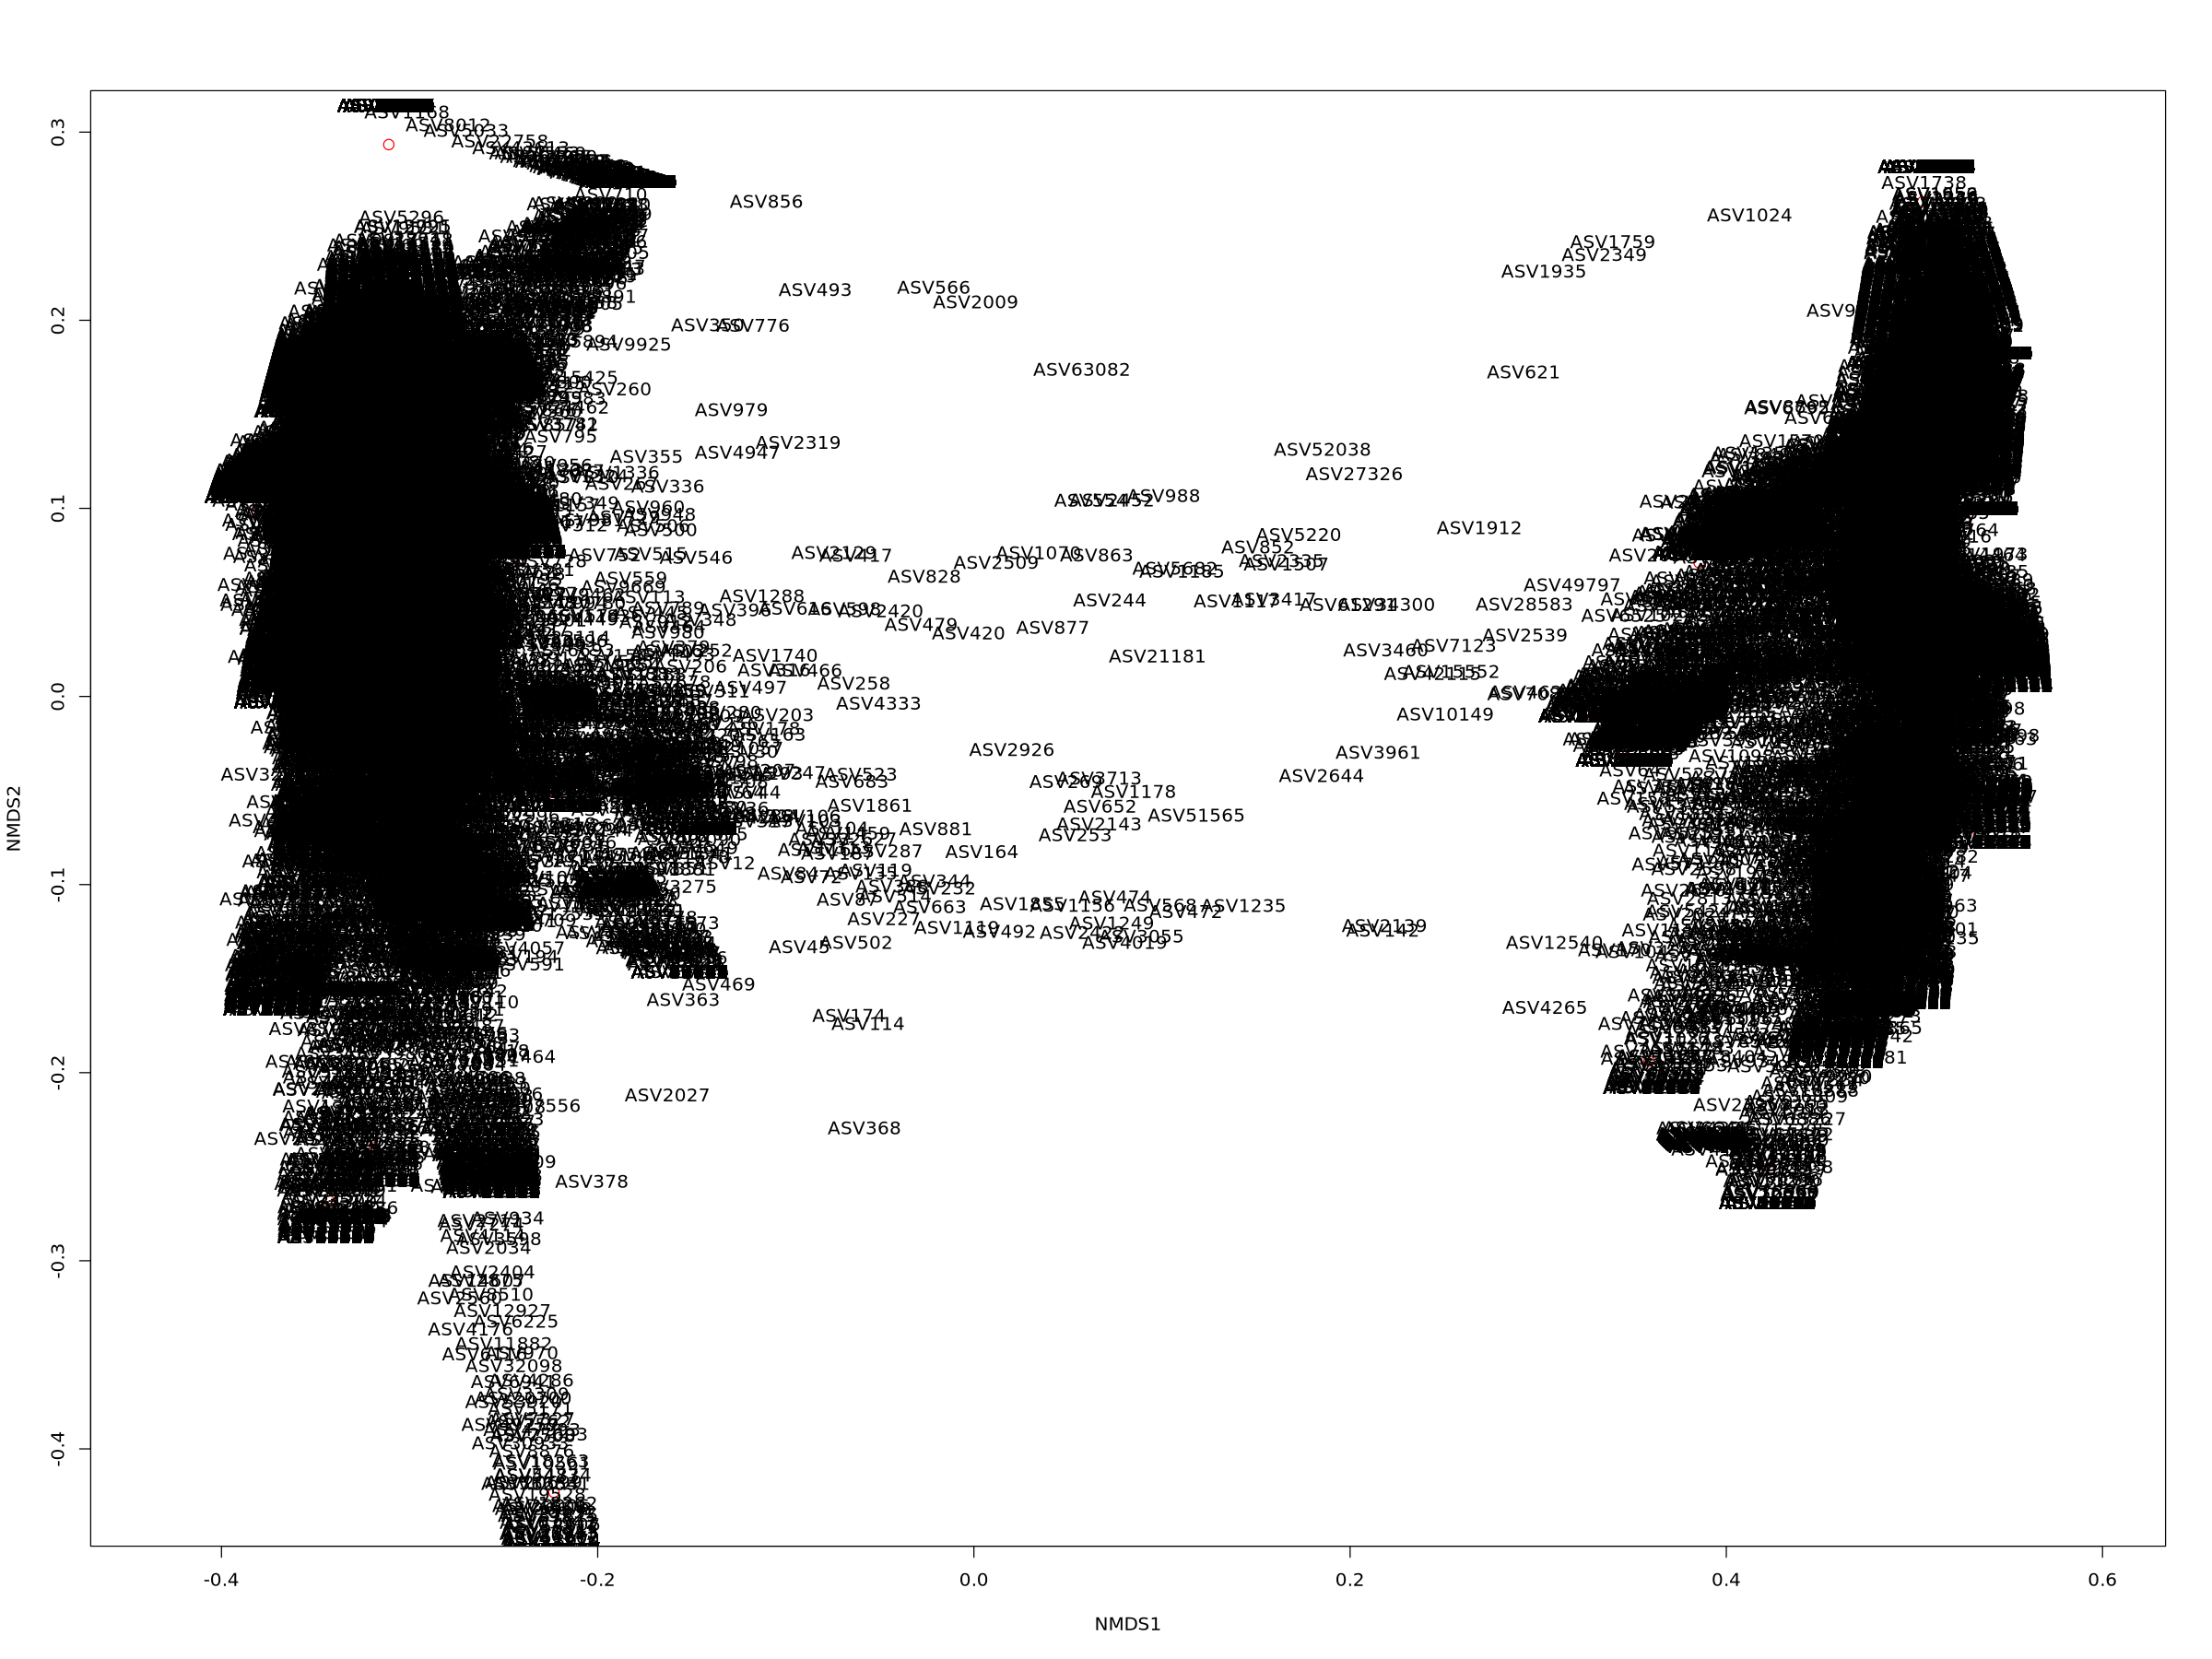

In [17]:
plot(NMDS2, display = "sites", type = "n")
points(NMDS2, display = "sites", col = "red", cex = 1.25)
text(NMDS2, display ="species")

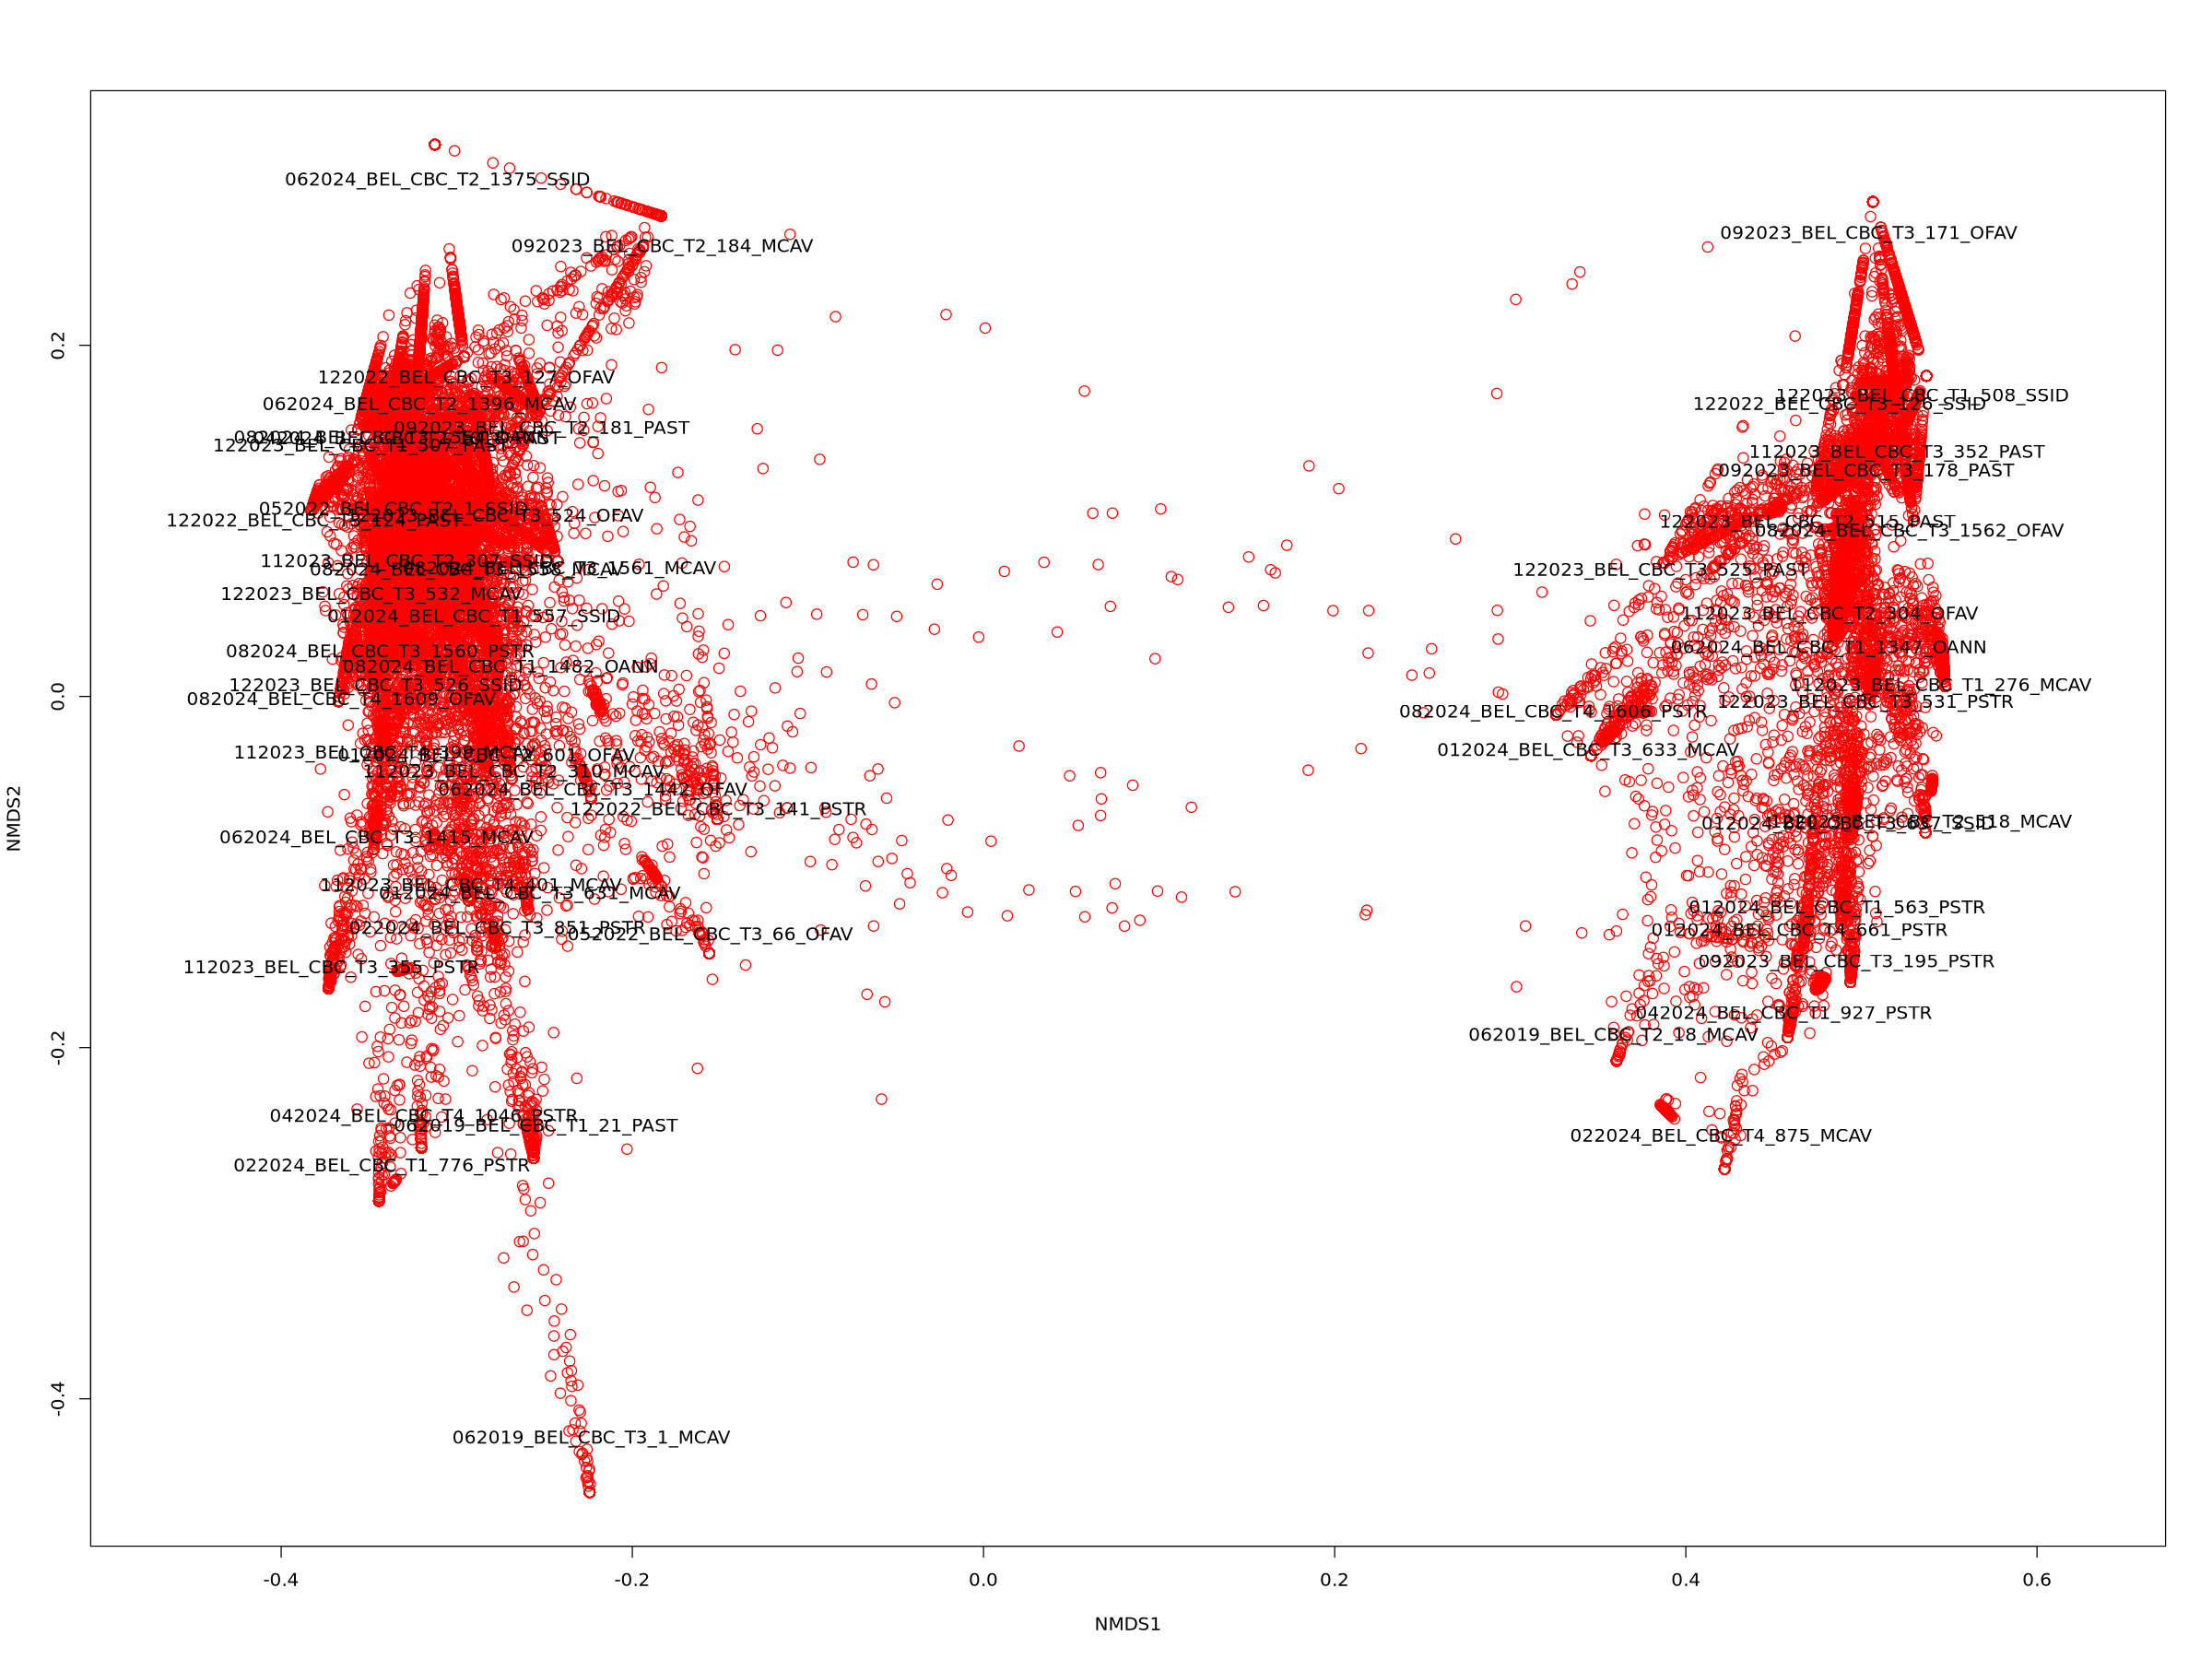

In [18]:
plot(NMDS2, display = "species", type = "n")
points(NMDS2, display = "species", col = "red", cex = 1.25)
text(NMDS2, display ="sites")

In [19]:
# Check matching sample order
all(rownames(NMDS2$points) == rownames(sample_norm))  # Should be TRUE

[1] TRUE


***FACTORS:

Centroids:
                               NMDS1   NMDS2
Health_StatusDiseased_Tissue -0.3457 -0.0813
Health_StatusHealthy          0.0062  0.0015
colony1_12                    0.1998 -0.1902
colony1_21                   -0.3048 -0.0517
colony1_24                    0.5452  0.0054
colony1_25                    0.1032  0.0215
colony1_3                     0.1221  0.1075
colony2_55                    0.1333 -0.0580
colony2_57                   -0.3284  0.1461
colony2_60                   -0.1828  0.2555
colony2_63                   -0.2518  0.1519
colony2_68                    0.4692  0.0985
colony2_69                    0.0189 -0.0142
colony2_73                   -0.3236  0.1996
colony2_76                    0.4819  0.0462
colony2_79                   -0.2831 -0.0346
colony2_99                   -0.3285  0.0761
colony3_10                    0.5201  0.1382
colony3_14                   -0.2942  0.0713
colony3_2                    -0.0748 -0.1786
colony3_20                   -

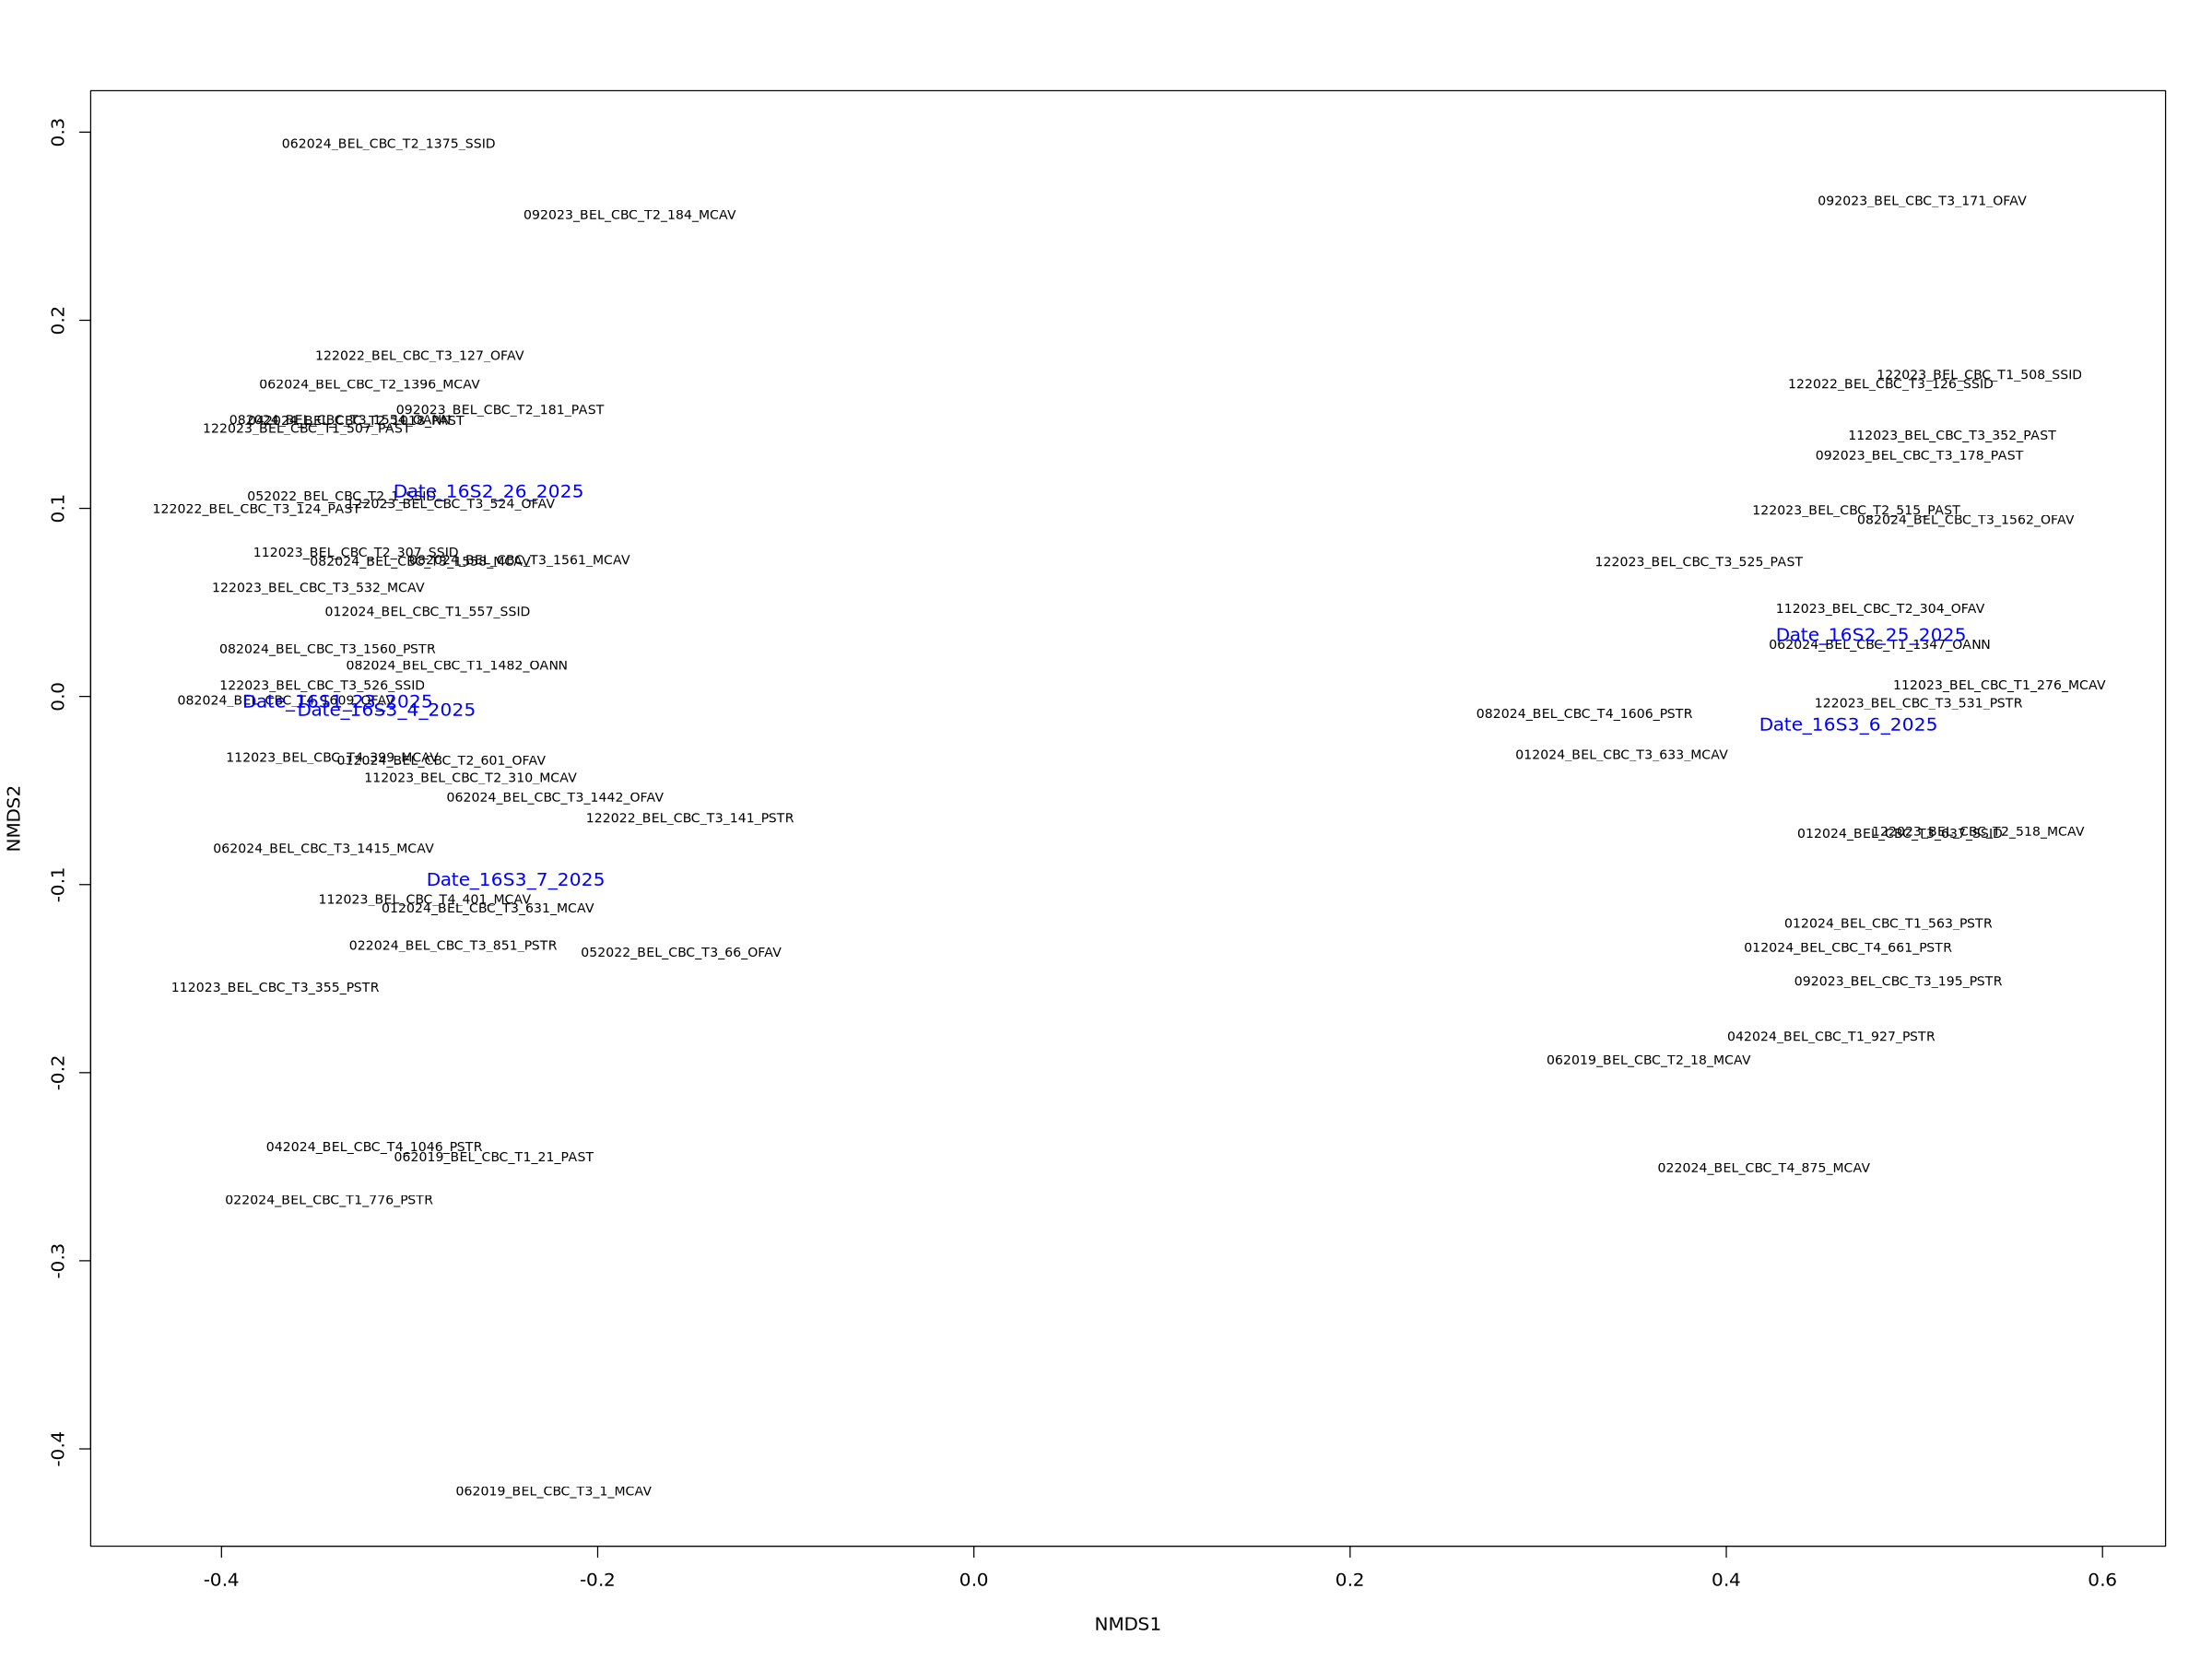

In [20]:
#vector fitting using a regression
# The function envfit will add the environmental variables as vectors to the ordination plot
ef <- envfit(NMDS2, sample_norm, permu = 999)
ef

# The two last columns are of interest: the squared correlation coefficient and the associated p-value
# Plot the vectors of the significant correlations and interpret the plot
plot(NMDS2, type = "t", display = "sites")
plot(ef, p.max = 0.05)

# Principle Component Analysis bi plots using vegan
- to help me visualize NMDS plots in a different way, uncover what is clustering on the X-axis

- plots PCA 1 and 2 along axes that are the variable, therefore is PCA1 is closer to species it is more impacted by species differences
- the first axis has the highest eigenvalue and thus explains the most variance

- The eigenvalues represent the variance extracted by each PC, and are often expressed as a percentage of the sum of all eigenvalues (i.e. total variance). 

In [21]:
set.seed(222)

In [23]:
#build PCA ord
PCA <- rda(otu_norm, scale = FALSE)

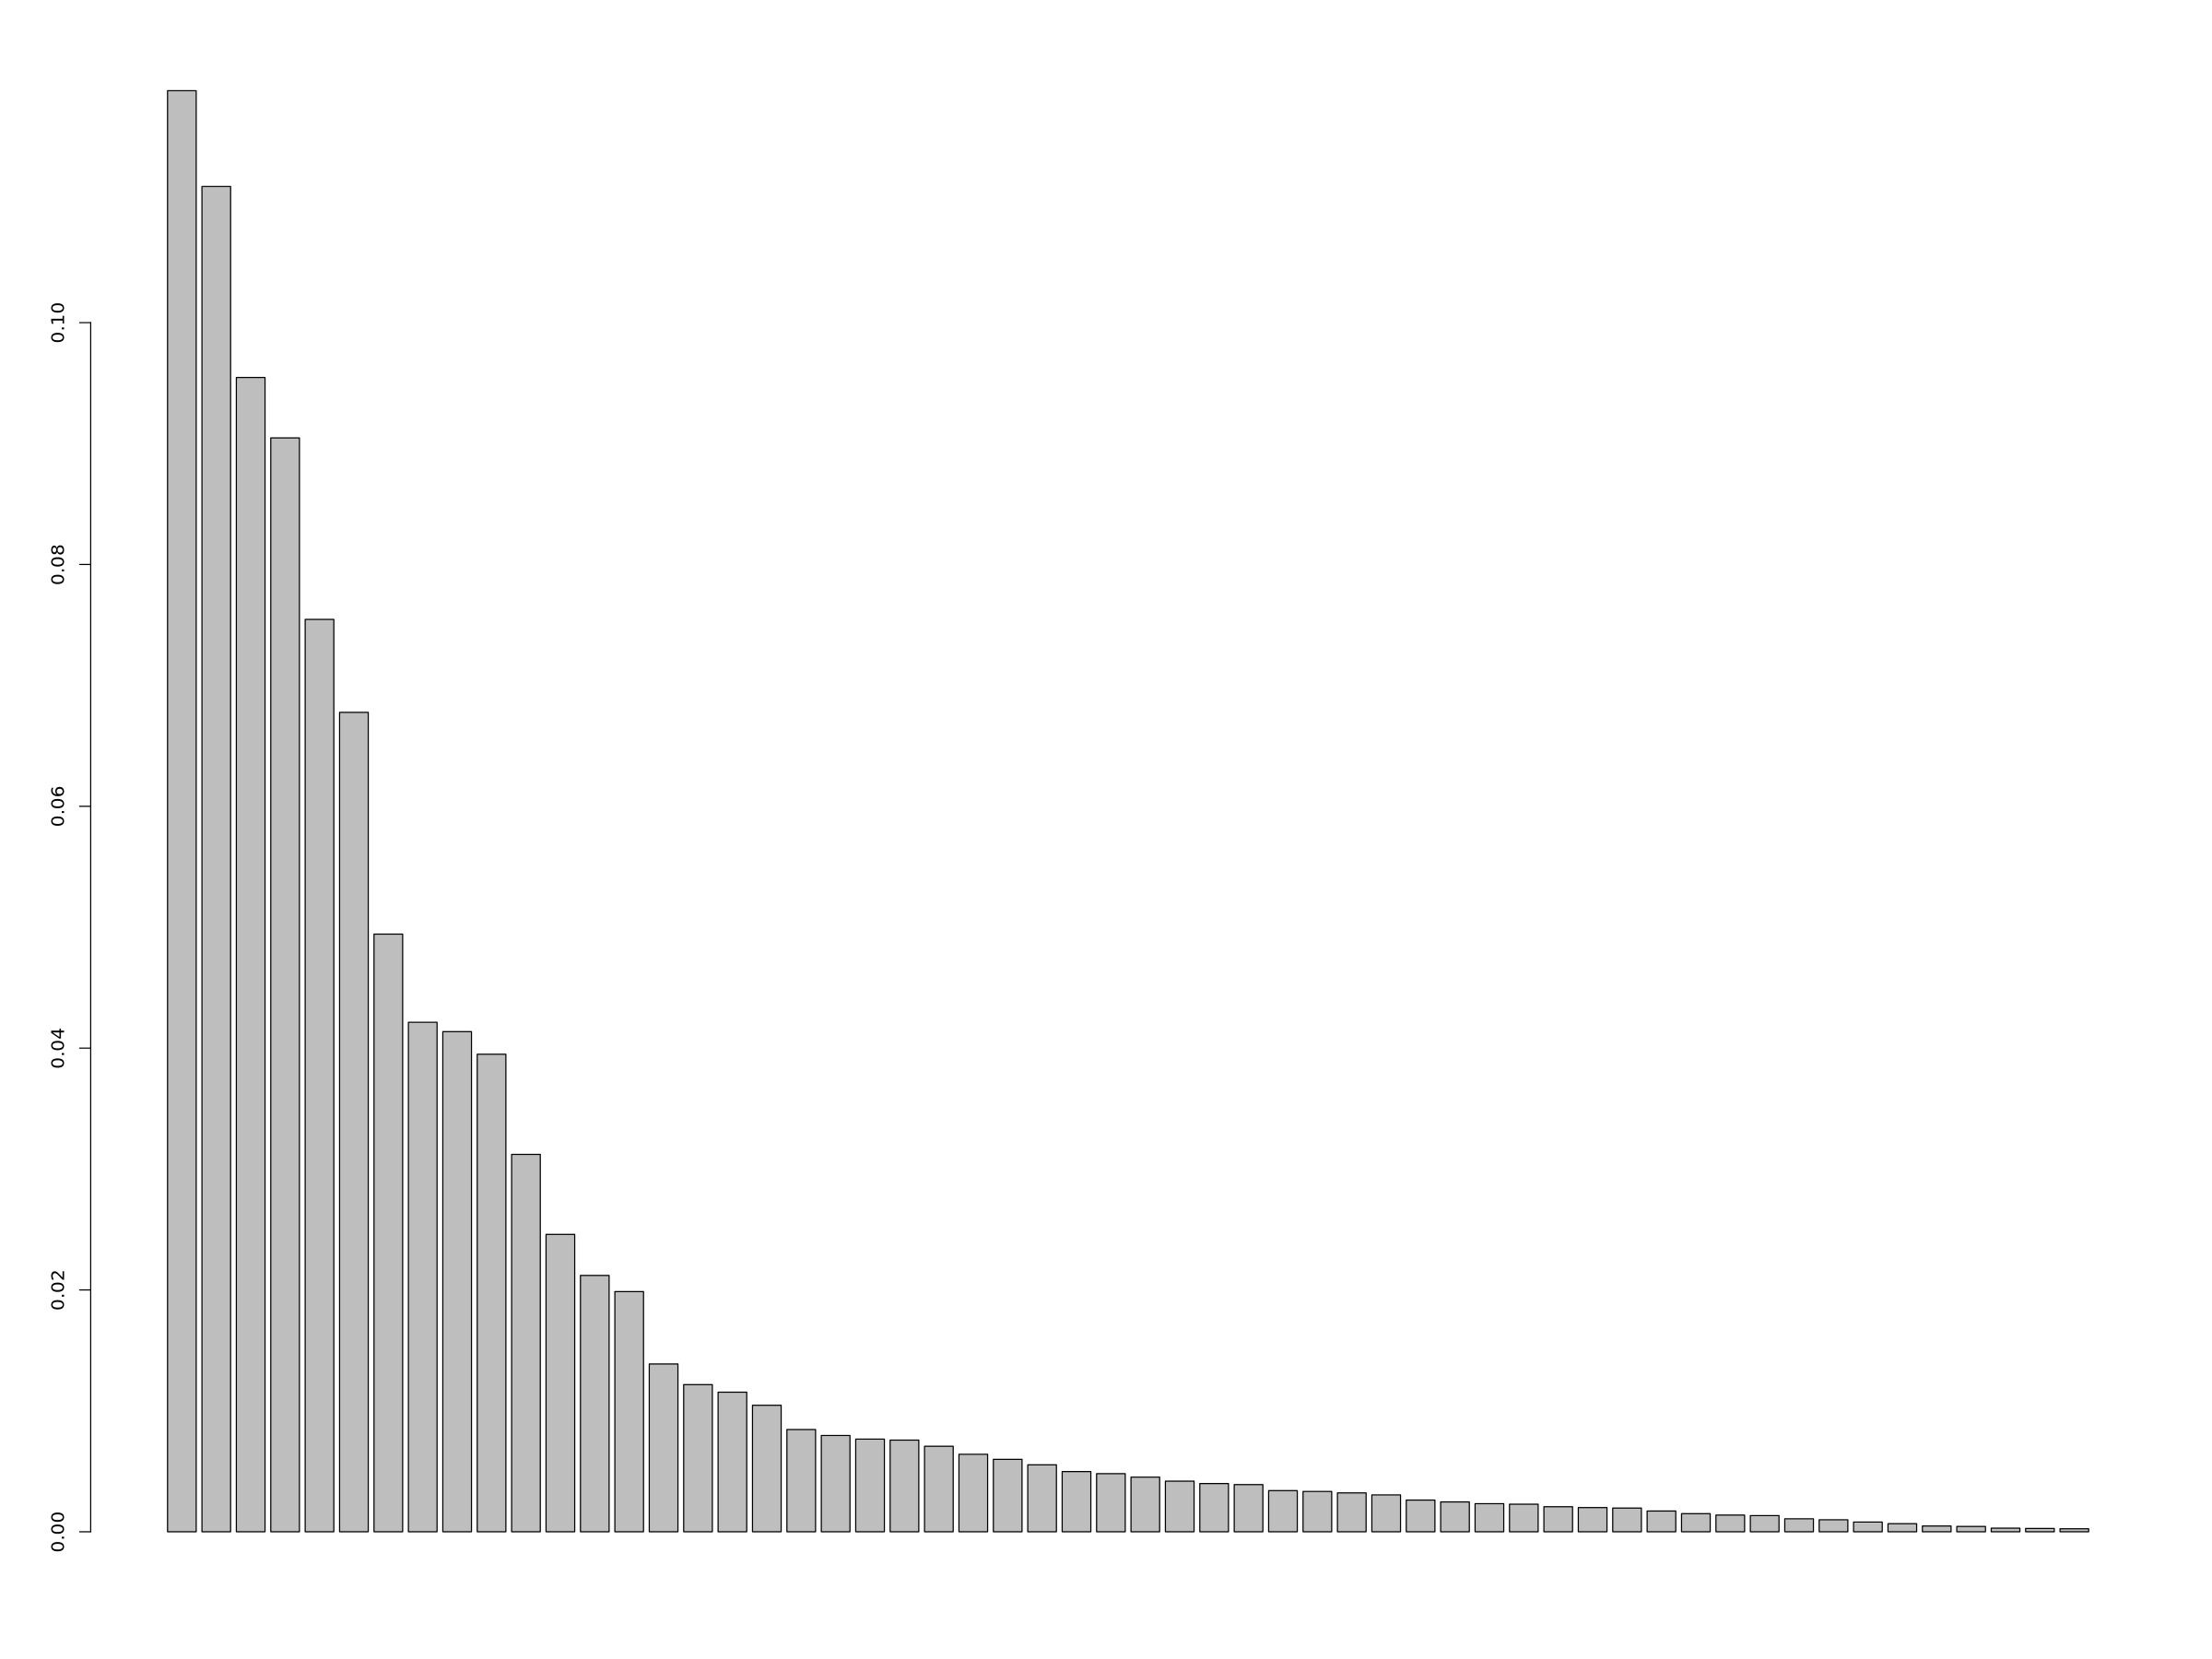

In [24]:
# Now plot a bar plot of relative eigenvalues. This is the percentage variance explained by each axis
barplot(as.vector(PCA$CA$eig)/sum(PCA$CA$eig)) 
# How much of the variance in our dataset is explained by the first principal component?

pca plots

In [ ]:
# Calculate the percent of variance explained by first two axes
sum((as.vector(PCA$CA$eig)/sum(PCA$CA$eig))[1:2]) 
# hmmm I do not like that the first two axes only explain 23% of variance


In [ ]:
# In a biplot of a PCA, species' scores are drawn as arrows 
# that point in the direction of increasing values for that variable
biplot(PCA, choices = c(1,2), type = c("text", "points"), xlim = c(-5,10)) # biplot of axis 1 vs 2

# Correspondence Analysis using vegan

In [ ]:
ord_ca <- ca() 
plot(ord_ca)

# what does kmeans actually do?

#This number of clusters should be determined according to the context and goal of your analysis (so according to your expectations or hypotheses)
model <- kmeans(otu_norm, centers = 2)

#The output model$cluster specifies the group (i.e., 1 or 2) to which each sample belongs to.
print(model$cluster)

calculate dissimilarity between samples using PERMANOVA in vegan

# df=n-1 

In [ ]:
# variables with no interaction
adonis2(vegdist(otu_norm, method = "bray") ~ species + transect + date + X16S.double.band, data = sample_norm)

In [ ]:
#variables with 2-way and 3- way interaction
adonis2(vegdist(otu_norm, method = "bray") ~ species * transect * X16S.double.band, data = sample_norm)

this specific code tests how much of the variation in Bray-Curtis distances can be explained by the combination of Experiment and Species, treating Species as nested within Experiment.
#adonis2(vegdist(otu_norm, method="bray") ~ Experiment/Species, data=sample_norm)


In [ ]:
#variables nested within eachother
#this one is species within transect with date as another variable
adonis2(vegdist(otu_norm, method = "bray") ~ transect/species + date, data = sample_norm)
